In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

# Local
import util
import utils


In [141]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 400

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [3]:
Legacy_BG_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/BG/full_legacy_no_colour_sel/reduced/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [4]:
Legacy_LRG_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/LRG/v4/LS_DESI_selection_full_sky/reduced/crs_lrg_nomaskbit_mask_4M_reduced_columns.fits"

In [7]:
SGA_parent_path = "/its/home/bb345/5-4most_data/other_data/LS_dr10_maskings/SGA-parent-v3.0.kd.fits"

In [11]:
BG = Table.read(Legacy_BG_path)

In [12]:
LRG = Table.read(Legacy_LRG_path)

In [8]:
SGA_parent = Table.read(SGA_parent_path)

In [13]:
BG = BG.to_pandas()

In [14]:
LRG = LRG.to_pandas()

In [15]:
BG = BG[BG.isBG_4M_v2]

In [16]:
LRG = LRG[LRG.isLRG_4M]

In [17]:
BG

,OBJID,RA,DEC,EBV,WISEMASK_W1,MASKBITS,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,isBG_4M_v2,desi_bgs_selection,galactic_cap,dr1_bg_mask
4,1219,157.028158,-2.272059,0.041179,0,0,True,False,True,18.530964,17.854332,19.707085,18.141018,17.936350,True,True,b'NGC',True
5,1576,157.035500,-2.270895,0.041186,0,0,True,False,True,18.154840,17.266401,19.582981,17.617146,16.646183,True,True,b'NGC',True
17,3463,157.078496,-2.132005,0.044005,0,0,True,False,True,18.284254,17.519909,19.758774,17.798515,17.251682,True,True,b'NGC',True
18,3745,157.084891,-2.167143,0.043157,0,0,True,False,True,18.479233,17.673344,19.868189,17.985254,17.257504,True,True,b'NGC',True
22,4712,157.105712,-2.330024,0.040446,0,0,False,False,True,19.159546,18.426689,20.465088,18.729229,18.386234,True,True,b'NGC',True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16742599,5810,144.798849,-5.314694,0.031073,0,0,False,False,True,19.037411,18.180340,20.642546,18.481697,17.805439,True,True,b'NGC',True
16742601,5878,144.800491,-5.198375,0.037407,0,0,False,False,True,19.102072,18.207945,20.844877,18.519903,17.744095,True,True,b'NGC',True
16742610,7637,144.842947,-5.309484,0.033186,0,0,True,False,True,18.839581,18.109055,20.154453,18.394375,17.980824,True,True,b'NGC',True
16742612,8023,144.852548,-5.135250,0.038222,0,0,True,False,True,18.828699,18.063553,20.319115,18.370508,17.842636,True,True,b'NGC',True


In [18]:
LRG

,OBJID,RA,DEC,EBV,WISEMASK_W1,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFDEPTH_G,...,Z_PHOT_STD,isLRG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_w1,mag_g,mag_fiberz,galactic_cap
0,531,334.194556,-45.331501,0.021752,0,1.613177,1.342430,1.177746,1.325987,4547.411621,...,0.052715,True,True,False,20.779900,19.772301,18.298798,22.118931,20.681299,b'SGC'
1,636,334.197982,-45.323136,0.021372,0,1.613177,1.354094,1.158701,1.323976,4547.411621,...,0.039985,True,True,False,21.875097,20.341349,18.723869,23.720015,21.460213,b'SGC'
2,692,334.199300,-45.340498,0.021901,0,1.580269,1.369656,1.177746,1.390829,4792.001953,...,0.038514,True,True,False,20.580793,19.457472,18.275036,21.720421,21.003563,b'SGC'
3,1133,334.213916,-45.355311,0.021866,0,1.557396,1.302155,1.156571,1.327200,4553.250977,...,0.032469,True,True,False,21.124153,19.391083,17.858835,22.997175,20.860195,b'SGC'
4,1177,334.215258,-45.244027,0.018549,0,1.612500,1.353601,1.150843,1.321957,4498.503906,...,0.059779,True,True,False,22.049360,20.385891,18.493507,23.487206,21.472549,b'SGC'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165877,7802,280.087826,-53.000011,0.080092,0,1.777501,1.775850,0.000000,1.417919,39.051941,...,0.142027,True,False,False,20.427456,19.333546,17.858925,21.920816,21.454433,b'SGC'
10165878,7907,280.091932,-53.055919,0.081667,0,1.823599,1.782116,1.271033,1.417919,334.816681,...,0.014762,True,False,False,18.665874,17.798912,17.295233,20.335766,19.010603,b'SGC'
10165879,7909,280.091964,-53.064687,0.082129,0,1.823599,1.786644,1.271033,1.417919,334.816681,...,0.021562,True,False,False,18.859930,17.952497,17.481071,20.581816,19.426792,b'SGC'
10165880,8048,280.097764,-52.955797,0.078708,0,1.809464,1.758398,0.000000,1.442846,360.970947,...,0.139892,True,False,False,21.647644,20.509701,18.286884,23.207256,21.146503,b'SGC'


In [19]:
SGA_parent = SGA_parent.to_pandas()

In [20]:
SGA_parent.columns

Index(['SGA_ID', 'GALAXY', 'PGC', 'RA', 'DEC', 'MORPHTYPE', 'PA_LEDA',
       'D25_LEDA', 'BA_LEDA', 'Z_LEDA', 'SB_D25_LEDA', 'MAG_LEDA', 'BYHAND',
       'REF', 'IN_FOOTPRINT', 'IN_FOOTPRINT_GRZ', 'GROUP_ID', 'GROUP_NAME',
       'GROUP_MULT', 'GROUP_PRIMARY', 'GROUP_RA', 'GROUP_DEC',
       'GROUP_DIAMETER', 'BRICKNAME', 'DIAM', 'DIAM_REF', 'PA', 'BA',
       'ELLIPSEBIT'],
      dtype='object')

In [32]:
SGA_parent.__dict__

{'_is_copy': None,
 '_mgr': BlockManager
 Items: Index(['SGA_ID', 'GALAXY', 'PGC', 'RA', 'DEC', 'MORPHTYPE', 'PA_LEDA',
        'D25_LEDA', 'BA_LEDA', 'Z_LEDA', 'SB_D25_LEDA', 'MAG_LEDA', 'BYHAND',
        'REF', 'IN_FOOTPRINT', 'IN_FOOTPRINT_GRZ', 'GROUP_ID', 'GROUP_NAME',
        'GROUP_MULT', 'GROUP_PRIMARY', 'GROUP_RA', 'GROUP_DEC',
        'GROUP_DIAMETER', 'BRICKNAME', 'DIAM', 'DIAM_REF', 'PA', 'BA',
        'ELLIPSEBIT'],
       dtype='object')
 Axis 1: RangeIndex(start=0, stop=531677, step=1)
 NumpyBlock: [12 14 15 19], 4 x 531677, dtype: bool
 NumpyBlock: [ 6  7  8  9 10 11 22 24 26 27], 10 x 531677, dtype: float32
 NumpyBlock: [ 3  4 20 21], 4 x 531677, dtype: float64
 NumpyBlock: slice(18, 19, 1), 1 x 531677, dtype: int16
 NumpyBlock: slice(28, 29, 1), 1 x 531677, dtype: int32
 NumpyBlock: [ 0  2 16], 3 x 531677, dtype: int64
 NumpyBlock: [ 1  5 13 17 23 25], 6 x 531677, dtype: object,
 '_item_cache': {'RA': 0         220.570200
  1         220.688857
  2         220.640990


In [21]:
SGA_parent

,SGA_ID,GALAXY,PGC,RA,DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,...,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT
0,311126,b'PGC681379',681379,220.570200,-33.078150,NaN,19.000000,0.363078,0.776247,-99.000000,...,True,220.570200,-33.078150,0.363078,b'2206m330',0.363078,b'LEDA',19.000000,0.776247,0
1,501509,b'PGC682697',682697,220.688857,-32.994727,NaN,33.500000,0.537032,0.371535,0.053084,...,True,220.688857,-32.994727,0.537032,b'2206m330',0.537032,b'LEDA',33.500000,0.371535,0
2,957176,b'PGC686514',686514,220.640990,-32.762573,b'S0-a',15.390000,0.375837,0.707946,0.052889,...,True,220.640990,-32.762573,0.375837,b'2207m327',0.375837,b'LEDA',15.390000,0.707946,0
3,1406807,b'ESO447-031',52454,220.231350,-32.375628,b'S0-a',152.839996,1.678804,0.477529,0.010143,...,True,220.231350,-32.375628,1.678804,b'2203m325',1.678804,b'LEDA',152.839996,0.477529,0
4,1307090,b'PGC694526',694526,220.713974,-32.268160,NaN,71.000000,0.354813,0.446684,-99.000000,...,True,220.713974,-32.268160,0.354813,b'2205m322',0.354813,b'LEDA',71.000000,0.446684,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531672,238187,b'PGC2072623',2072623,39.081666,35.956806,NaN,146.500000,0.338844,0.645654,-99.000000,...,False,39.073291,35.960235,1.231833,b'0389p360',0.338844,b'LEDA',146.500000,0.645654,0
531673,613182,b'PGC2072815',2072815,39.075834,35.967667,b'Sa',65.000000,0.769130,0.602560,0.030795,...,True,39.073291,35.960235,1.231833,b'0389p360',0.769130,b'LEDA',65.000000,0.602560,0
531674,1166866,b'PGC2073199',2073199,39.107416,35.990139,NaN,41.000000,0.645654,0.562341,0.031672,...,True,39.107416,35.990139,0.645654,b'0389p360',0.645654,b'LEDA',41.000000,0.562341,0
531675,497483,b'UGC02094',9912,39.214584,36.112611,b'SBc',0.000000,1.174898,0.916220,0.017124,...,True,39.214584,36.112611,1.174898,b'0392p360',1.174898,b'LEDA',0.000000,0.916220,0


In [26]:
bg = BG

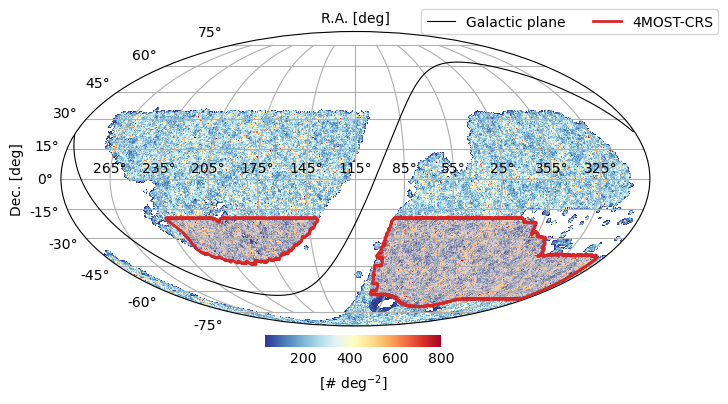

In [21]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

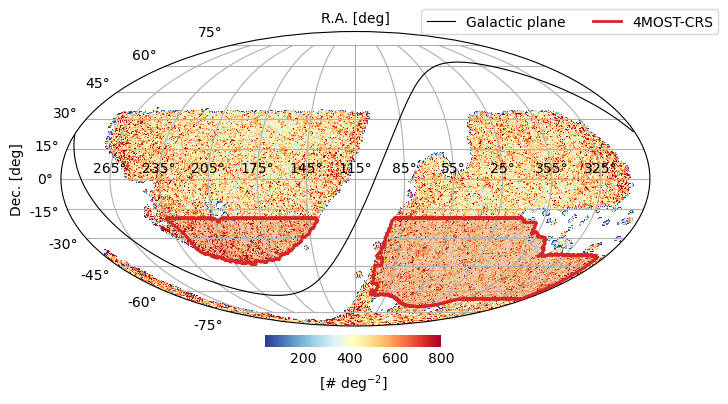

In [ ]:
hpmap = utils.create_hp_map(LRG['RA'], LRG['DEC'], nside=128)
utils.plot_moll_behnood(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

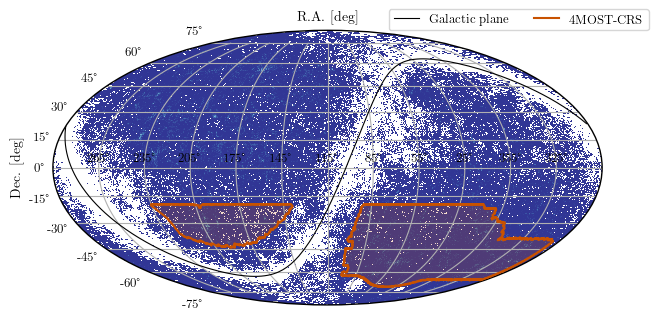

In [22]:
hpmap = utils.create_hp_map(SGA_parent['RA'], SGA_parent['DEC'], nside=128)
utils.plot_moll_behnood(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

In [29]:
SGA_parent_ra = SGA_parent['RA'].values        # numpy array of RA in deg
SGA_parent_dec = SGA_parent['DEC'].values      # Dec in deg

bg_ra = bg['RA'].values   # deg
bg_dec = bg['DEC'].values # deg

lrg_ra = LRG['RA'].values   # deg
lrg_dec = LRG['DEC'].values # deg

In [30]:
# Create SkyCoord objects for all Gaia stars and BG sources
SGA_parent_coords = SkyCoord(SGA_parent_ra * u.deg, SGA_parent_dec * u.deg, frame='icrs')
bg_coords   = SkyCoord(bg_ra * u.deg, bg_dec * u.deg, frame='icrs')
lrg_coords  = SkyCoord(lrg_ra * u.deg, lrg_dec * u.deg, frame='icrs')

In [121]:
# --- your existing bins & setup ---
mag_bins = [(8, 12), (12, 13), (13, 15), (15, 16)]
nbins    = 250
r_extent = 4.0
annulus  = (1, 200.0)
dr       = 0.1

# --- placeholder functions: replace with the real DR8/DR9 formulas ---
def mask_radius_DR9(g):
    # DR9 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. piecewise interpolation from Legacy Surveys DR9 prescription.
    # Here’s a toy example:
    return  10**(0.2*(13 - g))

def mask_radius_DR8(g):
    # DR8 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. a different piecewise curve published for DR8.
    # Here’s a toy example that’s ~1.7× larger than DR9:
    return 2 * mask_radius_DR9(g)

def mask_radius_for_mag(mag):
    # Returns a masking radius in degrees for a star of the given magnitude.
    # Used for Tycho-2 and Gaia stars.

    # This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].
    return 0.5*1630. * 1.396**(-mag)
# --- build BG SkyCoord once ---
cats = SkyCoord(ra=BG['RA'].values*u.deg,
                dec=BG['DEC'].values*u.deg)

In [119]:
BG_densities = {}
LRG_densities = {}

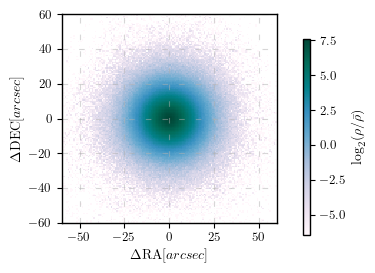

In [125]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.01, wspace=0.01)

ax = axes

i = 0

# # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
# bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
# stars = SkyCoord(ra=bright['RA'].values * u.deg,
#                 dec=bright['DEC'].values * u.deg)

# 3. Make a SkyCoord for your BG objects
cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                dec=BG['DEC'].values * u.deg)

# bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
stars  = SGA_parent_coords

# match & compute offsets
idx, _, _     = cats.match_to_catalog_sky(stars)
ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
dRAc = (ra_bg - ra_st)*np.cos(dec_st)
dDec = dec_bg - dec_st

# compute DR9 mask‐radii and scale
# mags_at_idx = bright['G'].values[idx]
# R9_arcsec   = mask_radius_DR9(mags_at_idx)
R_BS = 60
# R_BS_max = max(R_BS)

x = dRAc * 3600.0
y = dDec * 3600.0

# 8. Make a 2D histogram of (x,y)
# nbins = 200
H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-100,100],[-100,100]])
#  how to turn that into a density *ratio* η/η̄ ?
#  – compute the mean density in an annulus 1.1<R<4:
Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
XX, YY = np.meshgrid(Xc,Yc)
R = np.sqrt(XX**2 + YY**2)
mask = (R>annulus[0]) & (R<annulus[1])
eta_mean = H[mask].mean()
density_ratio = H / eta_mean

# 9. Plot
# fig, ax = plt.subplots(figsize=(6,6))
pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                    cmap='PuBuGn')

BG_densities = {
    'R_BS': R_BS,
    'x': x,
    'y': y,
    'H': H,
    'xe': xe,
    'ye': ye,
    'Xc': Xc,
    'Yc': Yc,
    'XX': XX,
    'YY': YY,
    'R': R,
    'eta_mean': eta_mean,
    'density_ratio': density_ratio,
    'nbins': nbins,
    'r_extent': r_extent,
    'annulus': annulus,
    'dr': dr
}
# 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
# for rad, col in [(1,'k'), (2,'b')]:
#     circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
#     ax.add_patch(circ)
# ax.text(
#     0.95, 0.95,
#     fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
#     transform=ax.transAxes,
#     verticalalignment='top',
#     horizontalalignment='right',
#     fontsize=BIGGER_SIZE,
#     bbox=dict(
#         facecolor='white',
#         alpha=1,
#         edgecolor='gray',
#         boxstyle='round,pad=0.3'
#     )
# )

# ax.set_xticks(np.arange(-3, 4, 1))
# ax.set_yticks(np.arange(-3, 4, 1))
ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
# ax.axhline(0, color='k', lw=1)
# ax.axvline(0, color='k', lw=1)
# ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
ax.set_xlabel(r'$\Delta\mathrm{RA}[arc sec]$')
ax.set_ylabel(r'$\Delta\mathrm{DEC}[arc sec]$')
i += 1

# axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
# axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
# axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

plt.tight_layout(rect=[0,0,0.9,1], h_pad=0.1, w_pad=0.1)
# plt.savefig('gaia_mask_BG.png', dpi=450, bbox_inches='tight')
# plt.savefig('gaia_mask_BG.pdf', dpi=450, bbox_inches='tight')
plt.show()



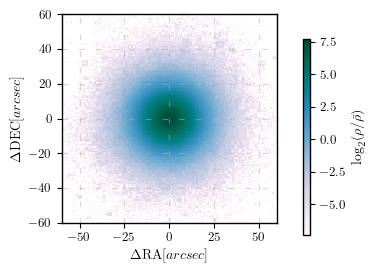

In [134]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.01, wspace=0.01)

ax = axes

i = 0

# # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
# bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
# stars = SkyCoord(ra=bright['RA'].values * u.deg,
#                 dec=bright['DEC'].values * u.deg)

# 3. Make a SkyCoord for your BG objects
cats  = SkyCoord(ra=LRG['RA'].values * u.deg,
                dec=LRG['DEC'].values * u.deg)

# bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
stars  = SGA_parent_coords

# match & compute offsets
idx, _, _     = cats.match_to_catalog_sky(stars)
ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
dRAc = (ra_bg - ra_st)*np.cos(dec_st)
dDec = dec_bg - dec_st

# compute DR9 mask‐radii and scale
# mags_at_idx = bright['G'].values[idx]
# R9_arcsec   = mask_radius_DR9(mags_at_idx)
R_BS = 60
# R_BS_max = max(R_BS)

x = dRAc * 3600.0
y = dDec * 3600.0

# 8. Make a 2D histogram of (x,y)
# nbins = 200
H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-100,100],[-100,100]])
#  how to turn that into a density *ratio* η/η̄ ?
#  – compute the mean density in an annulus 1.1<R<4:
Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
XX, YY = np.meshgrid(Xc,Yc)
R = np.sqrt(XX**2 + YY**2)
mask = (R>annulus[0]) & (R<annulus[1])
eta_mean = H[mask].mean()
density_ratio = H / eta_mean

# 9. Plot
# fig, ax = plt.subplots(figsize=(6,6))
pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                    cmap='PuBuGn')


# 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
# for rad, col in [(1,'k'), (2,'b')]:
#     circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
#     ax.add_patch(circ)
# ax.text(
#     0.95, 0.95,
#     fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
#     transform=ax.transAxes,
#     verticalalignment='top',
#     horizontalalignment='right',
#     fontsize=BIGGER_SIZE,
#     bbox=dict(
#         facecolor='white',
#         alpha=1,
#         edgecolor='gray',
#         boxstyle='round,pad=0.3'
#     )
# )

# ax.set_xticks(np.arange(-3, 4, 1))
# ax.set_yticks(np.arange(-3, 4, 1))
ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
# ax.axhline(0, color='k', lw=1)
# ax.axvline(0, color='k', lw=1)
# ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
ax.set_xlabel(r'$\Delta\mathrm{RA}[arc sec]$')
ax.set_ylabel(r'$\Delta\mathrm{DEC}[arc sec]$')
i += 1

# axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
# axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
# axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

plt.tight_layout(rect=[0,0,0.9,1], h_pad=0.1, w_pad=0.1)
# plt.savefig('gaia_mask_BG.png', dpi=450, bbox_inches='tight')
# plt.savefig('gaia_mask_BG.pdf', dpi=450, bbox_inches='tight')
plt.show()

LRG_densities = {
    'R_BS': R_BS,
    'x': x,
    'y': y,
    'H': H,
    'xe': xe,
    'ye': ye,
    'Xc': Xc,
    'Yc': Yc,
    'XX': XX,
    'YY': YY,
    'R': R,
    'eta_mean': eta_mean,
    'density_ratio': density_ratio,
    'nbins': nbins,
    'r_extent': r_extent,
    'annulus': annulus,
    'dr': dr
}

In [48]:
tracers = ['BG', 'LRG'] 

In [49]:
densities = [BG_densities, LRG_densities]

In [51]:
densities

[{'R_BS': 60,
  'x': array([-6.67061516, -6.20961216, -3.50992712, ..., -2.28159226,
          3.25953576,  5.9951834 ], shape=(5332111,)),
  'y': array([-9.98781917, -9.91468189, -1.18795923, ...,  0.47225932,
          4.99069038, -0.11047341], shape=(5332111,)),
  'H': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], shape=(250, 250)),
  'xe': array([-120.  , -119.04, -118.08, -117.12, -116.16, -115.2 , -114.24,
         -113.28, -112.32, -111.36, -110.4 , -109.44, -108.48, -107.52,
         -106.56, -105.6 , -104.64, -103.68, -102.72, -101.76, -100.8 ,
          -99.84,  -98.88,  -97.92,  -96.96,  -96.  ,  -95.04,  -94.08,
          -93.12,  -92.16,  -91.2 ,  -90.24,  -89.28,  -88.32,  -87.36,
          -86.4 ,  -85.44,  -84.48,  -83.52,  -82.56,  -81.6 ,  -80.64,
          -79.68,

In [82]:
color_map = ['PuBuGn', 'OrRd']

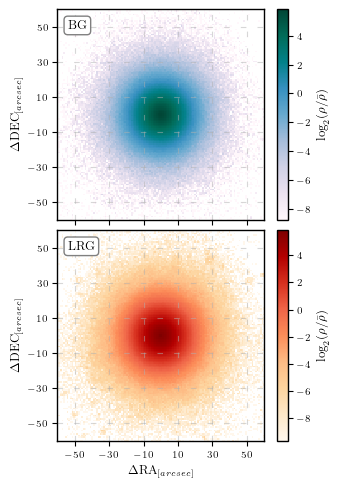

In [149]:
nrows = 2
ncols = 1
page_ratio = 1 # if it's one column 1, if two columns 2

fig, axes = plt.subplots(nrows, ncols, sharex=False, sharey=True, num=2, figsize=(sub_width*page_ratio, sub_height*nrows))
fig.subplots_adjust(hspace=0.05, wspace=0.01)

for i, ax in enumerate(axes):
    tracer = tracers[i]
    tracer_density = densities[i]

    R_BS = tracer_density['R_BS']
    x = tracer_density['x']
    y = tracer_density['y']

    H, xe, ye = tracer_density['H'], tracer_density['xe'], tracer_density['ye']
    Xc, Yc = tracer_density['Xc'], tracer_density['Yc']
    XX, YY = tracer_density['XX'], tracer_density['YY']
    R = np.sqrt(XX**2 + YY**2)
    mask = (R > annulus[0]) & (R < annulus[1])
    eta_mean = tracer_density['eta_mean']
    density_ratio = tracer_density['density_ratio']
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T, cmap=color_map[i])
    ax.grid(linestyle=(0, (5, 10)), alpha=0.5)
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.xaxis.set_ticks(np.arange(-50, 60, 20))
    ax.yaxis.set_ticks(np.arange(-50, 60, 20))

    if i == 1:
        ax.set_xlabel(r'$\Delta\mathrm{RA}_{[arc sec]}$')
    # if i == 0:
    ax.set_ylabel(r'$\Delta\mathrm{DEC}_{[arc sec]}$')
    ax.text(
        0.05, 0.95, tracer,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=MEDIUM_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    # if i == 1:
    fig.colorbar(pcm, ax=ax, orientation='vertical', label=r'$\log_2(\rho/\bar\rho)$')
    # else:
    #     fig.colorbar(pcm, ax=ax, orientation='vertical')
# cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

# plt.tight_layout( h_pad=0.1, w_pad=1)
# plt.savefig('SGA_parent_mask_both_2x1.png', dpi=450,bbox_inches='tight')
# plt.savefig('SGA_parent_mask_both_2x1.pdf', dpi=450, bbox_inches='tight')
plt.show()


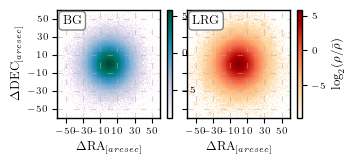

In [ ]:
nrows = 1
ncols = 2
page_ratio = 2 # if it's one column 1, if two columns 2

fig, axes = plt.subplots(nrows, ncols, sharex=False, sharey=True, num=2, figsize=(sub_width*page_ratio, sub_height*nrows))
fig.subplots_adjust(hspace=0.05, wspace=0.01)

for i, ax in enumerate(axes):
    tracer = tracers[i]
    tracer_density = densities[i]

    R_BS = tracer_density['R_BS']
    x = tracer_density['x']
    y = tracer_density['y']

    H, xe, ye = tracer_density['H'], tracer_density['xe'], tracer_density['ye']
    Xc, Yc = tracer_density['Xc'], tracer_density['Yc']
    XX, YY = tracer_density['XX'], tracer_density['YY']
    R = np.sqrt(XX**2 + YY**2)
    mask = (R > annulus[0]) & (R < annulus[1])
    eta_mean = tracer_density['eta_mean']
    density_ratio = tracer_density['density_ratio']
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T, cmap=color_map[i])
    ax.grid(linestyle=(0, (5, 10)), alpha=0.5)
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.xaxis.set_ticks(np.arange(-50, 70, 20))
    ax.yaxis.set_ticks(np.arange(-50, 70, 20))

    # if i == 1:
    ax.set_xlabel(r'$\Delta\mathrm{RA}_{[arc sec]}$')
    if i == 0:
        ax.set_ylabel(r'$\Delta\mathrm{DEC}_{[arc sec]}$')
    ax.text(
        0.05, 0.95, tracer,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=MEDIUM_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    if i == 1:
        fig.colorbar(pcm, ax=ax, orientation='vertical', label=r'$\log_2(\rho/\bar\rho)$')
    else:
        fig.colorbar(pcm, ax=ax, orientation='vertical')
# cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

# plt.tight_layout( h_pad=0.1, w_pad=1)
# plt.savefig('SGA_parent_mask_both_1x2.png', dpi=450,bbox_inches='tight')
# plt.savefig('SGA_parent_mask_both_1x2.pdf', dpi=450, bbox_inches='tight')
plt.show()


In [137]:
import pickle

In [140]:
with open('SGA_parent_BG_densities.pkl', 'wb') as f:
    pickle.dump(BG_densities, f)
with open('SGA_parent_LRG_densities.pkl', 'wb') as f:
    pickle.dump(LRG_densities, f)

In [139]:
pickle.dump(LRG_densities, open('LRG_densities_SGA_parent', 'wb'))